## **Analyze Voice of Social and L'Occitane en Provence Narratives**

In this notebook we first retrieve and perform sentiment analysis on **L'Occitane en Provence Tweets** using **TestBlob and Vader Python Libraries**.

Then, we depict the brand's **Narrative Arcs** using **text vectorization** and **kmeans clustering**

## **Introduction: Libraries and Credentials** 

In [ ]:
%%capture
# Import all needed libraries
import tweepy                   # Python wrapper around Twitter API
from google.colab import drive  # to mount Drive to Colab notebook

import pandas as pd
pd.set_option('display.max_colwidth', None) #to see more text
import json 
import csv
from datetime import date
from datetime import datetime
import time
import numpy as np
import re

# Dash 
!pip install dash
import dash_core_components as dcc

# Plotly 
import plotly
plotly.io.renderers.default = 'colab'
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp

# Matplotlib and Seaborn
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()

# Tensorflow
!pip install tensorflow_text
import tensorflow_hub as hub
import tensorflow_text as text

from textblob import TextBlob
from wordcloud import WordCloud
import string
import itertools
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Connect Google Drive to Colab
drive.mount('/content/gdrive')
# Create a variable to store the data path on your drive
path = './gdrive/My Drive/path/to/data'

Mounted at /content/gdrive


In [ ]:
# Twitter API credentials
api_key = 'XXXXXXXXXXXXXXXX'
api_secret_key = 'XXXXXXXXXXXXXXXX'
access_token = 'XXXXXXXXXXXXXXXX'
access_token_secret = 'XXXXXXXXXXXXXXXX'

In [ ]:
# Connect to Twitter API using the secrets
auth = tweepy.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [ ]:
# Helper function to save data into a JSON file
# file_name: the file name of the data on Google Drive
# file_content: the data you want to save
def save_json(file_name, file_content):
  with open(path + file_name, 'w', encoding='utf-8') as f:
    json.dump(file_content, f, ensure_ascii=False, indent=4)

In [ ]:
# Helper function to handle twitter API rate limit
def limit_handled(cursor, list_name):
  while True:
    try:
      yield cursor.next()
    # Catch Twitter API rate limit exception and wait for 15 minutes
    except tweepy.RateLimitError:
      print("\nData points in list = {}".format(len(list_name)))
      print('Hit Twitter API rate limit.')
      for i in range(3, 0, -1):
        print("Wait for {} mins.".format(i * 5))
        time.sleep(5 * 60)
    # Catch any other Twitter API exceptions
    except tweepy.error.TweepError:
      print('\nCaught TweepError exception' )

In [ ]:
# Define Microsoft Translation function 

# Microsoft Translation
import requests, uuid, json

def microsoft_translate(text):
  # Add your subscription key and endpoint
  subscription_key = 'XXXXXXXXXXXXXXXX'
  endpoint = "https://api.cognitive.microsofttranslator.com"

  # Add your location, also known as region. The default is global.
  # This is required if using a Cognitive Services resource.
  location = "westeurope"

  path = '/translate'
  constructed_url = endpoint + path

  params = {
      'api-version': '3.0',
      'to': 'en'
  }

  headers = {
      'Ocp-Apim-Subscription-Key': subscription_key,
      'Ocp-Apim-Subscription-Region': location,
      'Content-type': 'application/json',
      'X-ClientTraceId': str(uuid.uuid4())
  }

  # You can pass more than one object in body.
  body = [{
      'text': str(text)
  }]

  request = requests.post(constructed_url, params=params, headers=headers, json=body)
  response = request.json()

  # print(json.dumps(response, sort_keys=True, ensure_ascii=False, indent=4, separators=(',', ': ')))

  return response[0]['translations'][0]['text']

## **Get the account tweets**

In [ ]:
# List of L'Occitane and Erborian accounts on Twitter
Brands = ["LOCCITANE_UK","loccitane_jp"]

In [ ]:
data = []

for Brand in Brands:
  # initialize a list to hold all the Tweets
  alltweets = []
  # make initial request for most recent tweets 
  # (200 is the maximum allowed count)
  new_tweets = api.user_timeline(Brand,count=200)
  # save most recent tweets
  alltweets.extend(new_tweets)
  # save the id of the oldest tweet less one to avoid duplication
  oldest = alltweets[-1].id - 1
  # keep grabbing tweets until there are no tweets left
  while len(new_tweets) > 0:
      print("getting tweets before %s" % (oldest))
      # all subsequent requests use the max_id param to prevent
      # duplicates
      new_tweets = api.user_timeline(Brand,count=200,max_id=oldest)
      # save most recent tweets
      alltweets.extend(new_tweets)
      # update the id of the oldest tweet less one
      oldest = alltweets[-1].id - 1
      print("...%s tweets downloaded so far" % (len(alltweets)))
      ### END OF WHILE LOOP ###

  # transform the tweepy tweets into a list 
  # populate the list
  outtweets = [[Brand, tweet.id_str, tweet.created_at, tweet.text, tweet.favorite_count,tweet.in_reply_to_screen_name, tweet.retweeted] for tweet in alltweets]
  data = data + outtweets
  dftweets = pd.DataFrame(data, columns=["brand","id","created_at","text","likes","in reply to","retweeted"])
  print(dftweets["brand"].value_counts())

getting tweets before 1409074026220113919
...400 tweets downloaded so far
getting tweets before 1318486131084824582
...600 tweets downloaded so far
getting tweets before 1263452469931147269
...800 tweets downloaded so far
getting tweets before 1199984304052457472
...1000 tweets downloaded so far
getting tweets before 1141994240638984191
...1200 tweets downloaded so far
getting tweets before 1084389645092151296
...1400 tweets downloaded so far
getting tweets before 1055104904195301375
...1600 tweets downloaded so far
getting tweets before 1018792767793737728
...1798 tweets downloaded so far
getting tweets before 987249732614438912
...1996 tweets downloaded so far
getting tweets before 971369867885527039
...2194 tweets downloaded so far
getting tweets before 957904315972141055
...2390 tweets downloaded so far
getting tweets before 937969822545035263
...2590 tweets downloaded so far
getting tweets before 923533347703230463
...2789 tweets downloaded so far
getting tweets before 90329389103

**Now let's have a look at our dataset!**

In [ ]:
# Check the head of the dftweets
dftweets

,brand,id,created_at,text,likes,in reply to,retweeted
0,LOCCITANE_UK,1512004537942372355,2022-04-07 09:49:08,"@LauraGaribbo Hi Laura, we're so sorry to hear this. Please send a photo of your Eau de Toilette with the missing t… https://t.co/CioeM813xT",1,LauraGaribbo,False
1,LOCCITANE_UK,1511735515061514242,2022-04-06 16:00:08,"Get Egg-cited for Easter! 🐣🐇\n\nSurprise and delight your loved ones with our limited edition Easter eggs, featuring… https://t.co/HH15BAkTrU",11,None,False
2,LOCCITANE_UK,1511358834010296322,2022-04-05 15:03:20,@TheresaHanlon7 We hope you enjoyed your visit to our Market Street Boutique and look forward to welcoming you back… https://t.co/c4CfgVeVbV,0,TheresaHanlon7,False
3,LOCCITANE_UK,1510542632912449540,2022-04-03 09:00:02,We are so delighted to announce that we have won the @evening.standard award for Best Refillable Makeup &amp; Beauty Pr… https://t.co/g3nS3aGQp8,9,None,False
4,LOCCITANE_UK,1509817857432981511,2022-04-01 09:00:02,Happy Friday! Why not start of your weekend by unwinding from the busy week that has just gone by with our some of… https://t.co/7fVQQvmmcm,9,None,False
...,...,...,...,...,...,...,...
6458,loccitane_jp,192535673490780162,2012-04-18 08:50:56,明日、新しい“マルシェ”ショップがルミネ新宿2店にオープン!!当日はマルシェオープンバッグや、“色とりどり”マルシェ限定キットをご用意。数に限りがありますのでお早目に!!【PC・スマホ】http://t.co/uUiOQ1F3 【MB】http://t.co/AOC080fD,0,None,False
6459,loccitane_jp,192215288400457728,2012-04-17 11:37:50,年齢とともに気になりはじめる頬の毛穴。イモーテル ディヴァインセラムはキメをふっくら立ち上げ、なめらかな肌に導く美容液です。年齢が気になる肌を生き生きとした印象へ。【PC・スマホ】http://t.co/4Xyzneak【MB】http://t.co/jdU5RVGf,1,None,False
6460,loccitane_jp,192155731280142336,2012-04-17 07:41:11,人気の限定アイテムが送料・代引き手数料0円のお得なキャンペーンは明日4/18まで！見逃さないで。対象製品はこちら⇒【PC・スマホ】http://t.co/xBJTTIcn【MB】http://t.co/WFMrN48i,0,None,False
6461,loccitane_jp,191869350905528320,2012-04-16 12:43:12,ただいまヘアケアを含む限定アイテムにて、送料・代引き手数料キャンペーン中！4/18までとなっております。対象アイテムはこちら⇒【PC・スマホ】http://t.co/84MG9UyI【MB】http://t.co/oFPI3ITV,0,None,False


In [ ]:
# How many tweets do we have by brand/market? 
dftweets['brand'].value_counts()

LOCCITANE_UK    3238
loccitane_jp    3225
Name: brand, dtype: int64

Now let's **clean** our text column:

In [ ]:
# Clean the text

# Create a function to clean the tweets

def cleanTxt(text):
  text = re.sub(r'@[A-Za-z0-9_]+', '', text) #Revoming @mentions
  text = re.sub(r'#', '', text) # Removing the '#' simbol
  text = re.sub(r'RT[\s]+', '', text) # Removing RT
  text = re.sub(r'https?:\/\/\S+', '', text) # Removing the hyper link
  text = text.lower() # make text lowercase
  text = re.sub('\[.*?\]', '', text) # removing text within brackets
  text = re.sub('\(.*?\)', '', text) # removing text within parentheses
  text = re.sub('\w*\d\w*', '', text) # removing numbers
  text = re.sub('\s+', ' ', text) # if there's more than 1 whitespace, then make it just 1
  text = re.sub('\n', ' ', text) # if there's a new line, then make it a whitespace
  text = re.sub('\"+', '', text) # removing any quotes
  text = re.sub('(\&amp\;)', '', text) # removing &amp;
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Get rid of all punctuation
  text = re.sub('(httptco)', '', text) # getting rid of `httptco`
  text = re.sub(r'[^\w\s]', '',text) # remove other punctuation

  return text

# Cleaning the text
dftweets['text'] = dftweets['text'].apply(cleanTxt)

# Show the cleaned text
dftweets.head()

,brand,id,created_at,text,likes,in reply to,retweeted
0,LOCCITANE_UK,1512004537942372355,2022-04-07 09:49:08,hi laura were so sorry to hear this please send a photo of your eau de toilette with the missing t,1,LauraGaribbo,False
1,LOCCITANE_UK,1511735515061514242,2022-04-06 16:00:08,get eggcited for easter surprise and delight your loved ones with our limited edition easter eggs featuring,11,None,False
2,LOCCITANE_UK,1511358834010296322,2022-04-05 15:03:20,we hope you enjoyed your visit to our market street boutique and look forward to welcoming you back,0,TheresaHanlon7,False
3,LOCCITANE_UK,1510542632912449540,2022-04-03 09:00:02,we are so delighted to announce that we have won the standard award for best refillable makeup beauty pr,9,None,False
4,LOCCITANE_UK,1509817857432981511,2022-04-01 09:00:02,happy friday why not start of your weekend by unwinding from the busy week that has just gone by with our some of,9,None,False


## **Translate Tweets**

In [ ]:
# Loop through Japanese and Korean Tweets for Translation
for i in range(0,dftweets.shape[0]):
  print(i)
  if dftweets['brand'][i] in ['loccitane_jp','erborian_Korea']:
    dftweets['text'][i] = microsoft_translate(dftweets['text'][i])

dftweets

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


3239
3240
3241
3242
3243
3244
3245
3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298
3299
3300
3301
3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438


,brand,id,created_at,text,likes,in reply to,retweeted
0,LOCCITANE_UK,1512004537942372355,2022-04-07 09:49:08,hi laura were so sorry to hear this please send a photo of your eau de toilette with the missing t,1,LauraGaribbo,False
1,LOCCITANE_UK,1511735515061514242,2022-04-06 16:00:08,get eggcited for easter surprise and delight your loved ones with our limited edition easter eggs featuring,11,None,False
2,LOCCITANE_UK,1511358834010296322,2022-04-05 15:03:20,we hope you enjoyed your visit to our market street boutique and look forward to welcoming you back,0,TheresaHanlon7,False
3,LOCCITANE_UK,1510542632912449540,2022-04-03 09:00:02,we are so delighted to announce that we have won the standard award for best refillable makeup beauty pr,9,None,False
4,LOCCITANE_UK,1509817857432981511,2022-04-01 09:00:02,happy friday why not start of your weekend by unwinding from the busy week that has just gone by with our some of,9,None,False
...,...,...,...,...,...,...,...
6458,loccitane_jp,192535673490780162,2012-04-18 08:50:56,"Tomorrow the new Marche day, there is a limited number of marche open bags and colorful marche limited kits, so pc smartphone mb as soon as possible",0,None,False
6459,loccitane_jp,192215288400457728,2012-04-17 11:37:50,"Cheek pore Immortelle Divine Serum, which begins to be worried about with age, is a serum that plump ups and leads to smooth skin Pc smartphone to the impression that the skin that is anxious about age is lively",1,None,False
6460,loccitane_jp,192155731280142336,2012-04-17 07:41:11,The target product is this pc smartphone without missing the shipping cost of a popular limited item,0,None,False
6461,loccitane_jp,191869350905528320,2012-04-16 12:43:12,The target item during the postage collect on delivery fee campaign in the limited item including hair care now is this pc smartphone,0,None,False


In [ ]:
# Clean the text again (for JP tweets)

# Cleaning the text
dftweets['text'] = dftweets['text'].apply(cleanTxt)

# Show the cleaned text
dftweets.head()

,brand,id,created_at,text,likes,in reply to,retweeted
0,LOCCITANE_UK,1512004537942372355,2022-04-07 09:49:08,hi laura were so sorry to hear this please send a photo of your eau de toilette with the missing t,1,LauraGaribbo,False
1,LOCCITANE_UK,1511735515061514242,2022-04-06 16:00:08,get eggcited for easter surprise and delight your loved ones with our limited edition easter eggs featuring,11,None,False
2,LOCCITANE_UK,1511358834010296322,2022-04-05 15:03:20,we hope you enjoyed your visit to our market street boutique and look forward to welcoming you back,0,TheresaHanlon7,False
3,LOCCITANE_UK,1510542632912449540,2022-04-03 09:00:02,we are so delighted to announce that we have won the standard award for best refillable makeup beauty pr,9,None,False
4,LOCCITANE_UK,1509817857432981511,2022-04-01 09:00:02,happy friday why not start of your weekend by unwinding from the busy week that has just gone by with our some of,9,None,False


## **Sentiment Analysis**

### **Number of words and text length**

In [ ]:
dftweets['text_len'] = dftweets['text'].apply(lambda x: len(str(x).split()))
dftweets

,brand,id,created_at,text,likes,in reply to,retweeted,text_len
0,LOCCITANE_UK,1512004537942372355,2022-04-07 09:49:08,hi laura were so sorry to hear this please send a photo of your eau de toilette with the missing t,1,LauraGaribbo,False,21
1,LOCCITANE_UK,1511735515061514242,2022-04-06 16:00:08,get eggcited for easter surprise and delight your loved ones with our limited edition easter eggs featuring,11,None,False,17
2,LOCCITANE_UK,1511358834010296322,2022-04-05 15:03:20,we hope you enjoyed your visit to our market street boutique and look forward to welcoming you back,0,TheresaHanlon7,False,18
3,LOCCITANE_UK,1510542632912449540,2022-04-03 09:00:02,we are so delighted to announce that we have won the standard award for best refillable makeup beauty pr,9,None,False,19
4,LOCCITANE_UK,1509817857432981511,2022-04-01 09:00:02,happy friday why not start of your weekend by unwinding from the busy week that has just gone by with our some of,9,None,False,23
...,...,...,...,...,...,...,...,...
6458,loccitane_jp,192535673490780162,2012-04-18 08:50:56,tomorrow the new marche day there is a limited number of marche open bags and colorful marche limited kits so pc smartphone mb as soon as possible,0,None,False,27
6459,loccitane_jp,192215288400457728,2012-04-17 11:37:50,cheek pore immortelle divine serum which begins to be worried about with age is a serum that plump ups and leads to smooth skin pc smartphone to the impression that the skin that is anxious about age is lively,1,None,False,39
6460,loccitane_jp,192155731280142336,2012-04-17 07:41:11,the target product is this pc smartphone without missing the shipping cost of a popular limited item,0,None,False,17
6461,loccitane_jp,191869350905528320,2012-04-16 12:43:12,the target item during the postage collect on delivery fee campaign in the limited item including hair care now is this pc smartphone,0,None,False,23


In [ ]:
# Set number of words
dftweets.rename(columns={"text_len": "nb_words"}, inplace=True)
dftweets.head()

,brand,id,created_at,text,likes,in reply to,retweeted,nb_words
0,LOCCITANE_UK,1512004537942372355,2022-04-07 09:49:08,hi laura were so sorry to hear this please send a photo of your eau de toilette with the missing t,1,LauraGaribbo,False,21
1,LOCCITANE_UK,1511735515061514242,2022-04-06 16:00:08,get eggcited for easter surprise and delight your loved ones with our limited edition easter eggs featuring,11,None,False,17
2,LOCCITANE_UK,1511358834010296322,2022-04-05 15:03:20,we hope you enjoyed your visit to our market street boutique and look forward to welcoming you back,0,TheresaHanlon7,False,18
3,LOCCITANE_UK,1510542632912449540,2022-04-03 09:00:02,we are so delighted to announce that we have won the standard award for best refillable makeup beauty pr,9,None,False,19
4,LOCCITANE_UK,1509817857432981511,2022-04-01 09:00:02,happy friday why not start of your weekend by unwinding from the busy week that has just gone by with our some of,9,None,False,23


In [ ]:
# Set Text len
dftweets['text_len'] = dftweets['text'].astype(str).apply(len)
dftweets.head()

,brand,id,created_at,text,likes,in reply to,retweeted,nb_words,text_len
0,LOCCITANE_UK,1512004537942372355,2022-04-07 09:49:08,hi laura were so sorry to hear this please send a photo of your eau de toilette with the missing t,1,LauraGaribbo,False,21,100
1,LOCCITANE_UK,1511735515061514242,2022-04-06 16:00:08,get eggcited for easter surprise and delight your loved ones with our limited edition easter eggs featuring,11,None,False,17,108
2,LOCCITANE_UK,1511358834010296322,2022-04-05 15:03:20,we hope you enjoyed your visit to our market street boutique and look forward to welcoming you back,0,TheresaHanlon7,False,18,101
3,LOCCITANE_UK,1510542632912449540,2022-04-03 09:00:02,we are so delighted to announce that we have won the standard award for best refillable makeup beauty pr,9,None,False,19,105
4,LOCCITANE_UK,1509817857432981511,2022-04-01 09:00:02,happy friday why not start of your weekend by unwinding from the busy week that has just gone by with our some of,9,None,False,23,114


### **Subjectivity and Polarity with TextBlob**

In [ ]:
# Create a function to get the subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

# Create two new columns
dftweets['Subjectivity'] = dftweets['text'].apply(getSubjectivity)
dftweets['Polarity'] = dftweets['text'].apply(getPolarity)

# Show the new dataframe with the new columns
dftweets.head()

,brand,id,created_at,text,likes,in reply to,retweeted,nb_words,text_len,Subjectivity,Polarity
0,LOCCITANE_UK,1512004537942372355,2022-04-07 09:49:08,hi laura were so sorry to hear this please send a photo of your eau de toilette with the missing t,1,LauraGaribbo,False,21,100,0.525000,-0.350000
1,LOCCITANE_UK,1511735515061514242,2022-04-06 16:00:08,get eggcited for easter surprise and delight your loved ones with our limited edition easter eggs featuring,11,None,False,17,108,0.471429,0.314286
2,LOCCITANE_UK,1511358834010296322,2022-04-05 15:03:20,we hope you enjoyed your visit to our market street boutique and look forward to welcoming you back,0,TheresaHanlon7,False,18,101,0.350000,0.250000
3,LOCCITANE_UK,1510542632912449540,2022-04-03 09:00:02,we are so delighted to announce that we have won the standard award for best refillable makeup beauty pr,9,None,False,19,105,0.333333,0.566667
4,LOCCITANE_UK,1509817857432981511,2022-04-01 09:00:02,happy friday why not start of your weekend by unwinding from the busy week that has just gone by with our some of,9,None,False,23,114,0.650000,0.450000


In [ ]:
dftweets.head()

,brand,id,created_at,text,likes,in reply to,retweeted,nb_words,text_len,Subjectivity,Polarity
0,LOCCITANE_UK,1512004537942372355,2022-04-07 09:49:08,hi laura were so sorry to hear this please send a photo of your eau de toilette with the missing t,1,LauraGaribbo,False,21,100,0.525000,-0.350000
1,LOCCITANE_UK,1511735515061514242,2022-04-06 16:00:08,get eggcited for easter surprise and delight your loved ones with our limited edition easter eggs featuring,11,None,False,17,108,0.471429,0.314286
2,LOCCITANE_UK,1511358834010296322,2022-04-05 15:03:20,we hope you enjoyed your visit to our market street boutique and look forward to welcoming you back,0,TheresaHanlon7,False,18,101,0.350000,0.250000
3,LOCCITANE_UK,1510542632912449540,2022-04-03 09:00:02,we are so delighted to announce that we have won the standard award for best refillable makeup beauty pr,9,None,False,19,105,0.333333,0.566667
4,LOCCITANE_UK,1509817857432981511,2022-04-01 09:00:02,happy friday why not start of your weekend by unwinding from the busy week that has just gone by with our some of,9,None,False,23,114,0.650000,0.450000


### **Polarity and Intensity with VADER**

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
sentiment = dftweets['text'].apply(lambda x: analyzer.polarity_scores(str(x)))
dftweets = pd.concat([dftweets,sentiment.apply(pd.Series)],1)

In [ ]:
dftweets.rename(columns={'Subjectivity':'subjectivity', 'Polarity':'polarity', 'neg':'negative',
                         'neu':'neutral', 'pos':'positive'}, inplace=True)
dftweets.head()

,brand,id,created_at,text,likes,in reply to,retweeted,nb_words,text_len,subjectivity,polarity,negative,neutral,positive,compound
0,LOCCITANE_UK,1512004537942372355,2022-04-07 09:49:08,hi laura were so sorry to hear this please send a photo of your eau de toilette with the missing t,1,LauraGaribbo,False,21,100,0.525000,-0.350000,0.175,0.709,0.116,-0.0814
1,LOCCITANE_UK,1511735515061514242,2022-04-06 16:00:08,get eggcited for easter surprise and delight your loved ones with our limited edition easter eggs featuring,11,None,False,17,108,0.471429,0.314286,0.077,0.524,0.399,0.8402
2,LOCCITANE_UK,1511358834010296322,2022-04-05 15:03:20,we hope you enjoyed your visit to our market street boutique and look forward to welcoming you back,0,TheresaHanlon7,False,18,101,0.350000,0.250000,0.000,0.622,0.378,0.8442
3,LOCCITANE_UK,1510542632912449540,2022-04-03 09:00:02,we are so delighted to announce that we have won the standard award for best refillable makeup beauty pr,9,None,False,19,105,0.333333,0.566667,0.000,0.419,0.581,0.9659
4,LOCCITANE_UK,1509817857432981511,2022-04-01 09:00:02,happy friday why not start of your weekend by unwinding from the busy week that has just gone by with our some of,9,None,False,23,114,0.650000,0.450000,0.000,0.856,0.144,0.5719


### **Save CSV File**

In [ ]:
dftweets.to_csv("/content/gdrive/MyDrive/Kedge Thesis: Voice of Stakeholders/Socials/Brand_Tweet_Posts.csv")

In [ ]:
dftweets.tail()

,brand,id,created_at,text,likes,in reply to,retweeted,nb_words,text_len,subjectivity,polarity,negative,neutral,positive,compound
6458,loccitane_jp,192535673490780162,2012-04-18 08:50:56,tomorrow the new marche day there is a limited number of marche open bags and colorful marche limited kits so pc smartphone mb as soon as possible,0,None,False,27,146,0.440043,0.048918,0.135,0.819,0.046,-0.3612
6459,loccitane_jp,192215288400457728,2012-04-17 11:37:50,cheek pore immortelle divine serum which begins to be worried about with age is a serum that plump ups and leads to smooth skin pc smartphone to the impression that the skin that is anxious about age is lively,1,None,False,39,209,0.666667,0.095455,0.092,0.724,0.184,0.6369
6460,loccitane_jp,192155731280142336,2012-04-17 07:41:11,the target product is this pc smartphone without missing the shipping cost of a popular limited item,0,None,False,17,100,0.364286,0.109524,0.097,0.664,0.239,0.4191
6461,loccitane_jp,191869350905528320,2012-04-16 12:43:12,the target item during the postage collect on delivery fee campaign in the limited item including hair care now is this pc smartphone,0,None,False,23,133,0.142857,-0.071429,0.073,0.805,0.123,0.3182
6462,loccitane_jp,191839014733627392,2012-04-16 10:42:39,for those who tend to be hypersensitive because the condition of the skin is not stable in spring the shea rich moisture cream is recommended to wrap around the entire palm of the hand and make a gentle moisture pc smartphone,1,None,False,41,225,0.725000,0.191667,0.039,0.723,0.238,0.8629


## **Narrative Arcs**

### **Evolution of Likes, Texts and Sentiment**

In [ ]:
# Load df
dftweets = pd.read_csv("/content/gdrive/MyDrive/Kedge Thesis: Voice of Stakeholders/Socials/Brand_Tweet_Posts.csv")
dftweets['created_at'] = pd.to_datetime(dftweets['created_at'])
dftweets['brand'] = dftweets['brand'].replace({'LOCCITANE_UK':'UK','loccitane_jp':'JP'})
dftweets = dftweets.iloc[:, 1:]

In [ ]:
# Split data by brand
dftweetsuk = dftweets[dftweets['brand']=='UK']
dftweetsjp = dftweets[dftweets['brand']=='JP']

In [ ]:
# Define Datasets
df_line_likes_uk = dftweetsuk[['created_at','likes']].groupby('created_at').sum()
df_line_likes_uk = df_line_likes_uk.reset_index().dropna()
df_line_likes_uk['time'] = df_line_likes_uk['created_at'].dt.strftime('%Y-%m')
df_line_likes_uk = df_line_likes_uk[['time','likes']].groupby('time').sum()
df_line_likes_uk = df_line_likes_uk.reset_index().dropna()
df_line_likes_uk.head()

# Set y axis range
ymax, ymin = 500, 0

# Create Line plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_line_likes_uk['time'], y=df_line_likes_uk['likes'], name = 'UK',
                         line=dict(color=px.colors.qualitative.Pastel[4], width=3)))


# Set Line chart properties 
layout = go.Layout(
    title="Number of Twitter Likes through Time - L'Occitane UK",
    title_x=0.5,
    plot_bgcolor="#FFF",  # Sets background color to white
    xaxis=dict(
        title="Year",
        linecolor="#BCCCDC",  # Sets color of X-axis line
        showgrid=False  # Removes X-axis grid lines
    ),
    yaxis=dict(
        title="Total Likes",  
        linecolor="#BCCCDC",  # Sets color of Y-axis line
        showgrid=False,  # Removes Y-axis grid lines    
    )
)
fig.update_layout(layout)
#fig.update_yaxes(range=[ymin, ymax])

# Display the Line plot
fig.show()

In [ ]:
# Define Datasets
df_line_likes_jp = dftweetsjp[['created_at','likes']].groupby('created_at').sum()
df_line_likes_jp = df_line_likes_jp.reset_index().dropna()
df_line_likes_jp['time'] = df_line_likes_jp['created_at'].dt.strftime('%Y-%m')
df_line_likes_jp = df_line_likes_jp[['time','likes']].groupby('time').sum()
df_line_likes_jp = df_line_likes_jp.reset_index().dropna()
df_line_likes_jp.head()

# Set y axis range
ymax, ymin = 500, 0

# Create Line plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_line_likes_jp['time'], y=df_line_likes_jp['likes'], name = 'JP',
                         line=dict(color=px.colors.qualitative.Pastel[5], width=3)))


# Set Line chart properties 
layout = go.Layout(
    title="Number of Twitter Likes through Time - L'Occitane JP",
    title_x=0.5,
    plot_bgcolor="#FFF",  # Sets background color to white
    xaxis=dict(
        title="Year",
        linecolor="#BCCCDC",  # Sets color of X-axis line
        showgrid=False  # Removes X-axis grid lines
    ),
    yaxis=dict(
        title="Total Likes",  
        linecolor="#BCCCDC",  # Sets color of Y-axis line
        showgrid=False,  # Removes Y-axis grid lines    
    )
)
fig.update_layout(layout)
#fig.update_yaxes(range=[ymin, ymax])

# Display the Line plot
fig.show()

In [ ]:
# Define Dataset
df_line_sen_uk = dftweetsuk[['created_at','nb_words','text_len']].groupby('created_at').mean()
df_line_sen_uk = df_line_sen_uk.reset_index().dropna()
df_line_sen_uk['time'] = df_line_sen_uk['created_at'].dt.strftime('%Y-%m')
df_line_sen_uk = df_line_sen_uk[['time','nb_words','text_len']].groupby('time').sum()
df_line_sen_uk = df_line_sen_uk.reset_index().dropna()
df_line_sen_uk.head()

# Create Line plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_line_sen_uk['time'], y=df_line_sen_uk['nb_words'], name = 'Words',
                         line=dict(color=px.colors.qualitative.Pastel[4], width=3)))
fig.add_trace(go.Scatter(x=df_line_sen_uk['time'], y=df_line_sen_uk['text_len'], name = 'Characters',
                         line=dict(color=px.colors.qualitative.Pastel[7], width=3)))

# Set Line chart properties 
layout = go.Layout(
    title="Texte length through Time - L'Occitane UK",
    title_x=0.5,
    plot_bgcolor="#FFF",  # Sets background color to white
    xaxis=dict(
        title="Time",
        linecolor="#BCCCDC",  # Sets color of X-axis line
        showgrid=False  # Removes X-axis grid lines
    ),
    yaxis=dict(
        title="Text length",  
        linecolor="#BCCCDC",  # Sets color of Y-axis line
        showgrid=False,  # Removes Y-axis grid lines    
    )
)
fig.update_layout(layout)

# Display the Line plot
fig.show()

In [ ]:
# Define Dataset
df_line_sen_jp = dftweetsjp[['created_at','nb_words','text_len']].groupby('created_at').mean()
df_line_sen_jp = df_line_sen_jp.reset_index().dropna()
df_line_sen_jp['time'] = df_line_sen_jp['created_at'].dt.strftime('%Y-%m')
df_line_sen_jp = df_line_sen_jp[['time','nb_words','text_len']].groupby('time').sum()
df_line_sen_jp = df_line_sen_jp.reset_index().dropna()
df_line_sen_jp.head()

# Create Line plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_line_sen_jp['time'], y=df_line_sen_jp['nb_words'], name = 'Words',
                         line=dict(color=px.colors.qualitative.Pastel[9], width=3)))
fig.add_trace(go.Scatter(x=df_line_sen_jp['time'], y=df_line_sen_jp['text_len'], name = 'Characters',
                         line=dict(color=px.colors.qualitative.Pastel[5], width=3)))

# Set Line chart properties 
layout = go.Layout(
    title="Texte length through Time - L'Occitane JP",
    title_x=0.5,
    plot_bgcolor="#FFF",  # Sets background color to white
    xaxis=dict(
        title="Time",
        linecolor="#BCCCDC",  # Sets color of X-axis line
        showgrid=False  # Removes X-axis grid lines
    ),
    yaxis=dict(
        title="Text length",  
        linecolor="#BCCCDC",  # Sets color of Y-axis line
        showgrid=False,  # Removes Y-axis grid lines    
    )
)
fig.update_layout(layout)

# Display the Line plot
fig.show()

In [ ]:
# Define Dataset
df_line_sen_uk = dftweetsuk[['created_at','subjectivity','polarity','negative','neutral','positive','compound']].groupby('created_at').mean()
df_line_sen_uk = df_line_sen_uk.reset_index().dropna()
df_line_sen_uk['time'] = df_line_sen_uk['created_at'].dt.strftime('%Y-%m')
df_line_sen_uk = df_line_sen_uk[['time','subjectivity','polarity','negative','neutral','positive','compound']].groupby('time').sum()
df_line_sen_uk = df_line_sen_uk.reset_index().dropna()
df_line_sen_uk.head()

# Create Line plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_line_sen_uk['time'], y=df_line_sen_uk['subjectivity'], name = 'Subjectivity',
                         line=dict(color=px.colors.qualitative.Pastel[4], width=3)))
fig.add_trace(go.Scatter(x=df_line_sen_uk['time'], y=df_line_sen_uk['polarity'], name = 'Polarity',
                         line=dict(color=px.colors.qualitative.Pastel[7], width=3)))
fig.add_trace(go.Scatter(x=df_line_sen_uk['time'], y=df_line_sen_uk['compound'], name = 'Compound',
                         line=dict(color=px.colors.qualitative.Pastel[2], width=3)))



# Set Line chart properties 
layout = go.Layout(
    title="Sentiment through Time - L'Occitane UK",
    title_x=0.5,
    plot_bgcolor="#FFF",  # Sets background color to white
    xaxis=dict(
        title="Time",
        linecolor="#BCCCDC",  # Sets color of X-axis line
        showgrid=False  # Removes X-axis grid lines
    ),
    yaxis=dict(
        title="Sentiment",  
        linecolor="#BCCCDC",  # Sets color of Y-axis line
        showgrid=False,  # Removes Y-axis grid lines    
    )
)
fig.update_layout(layout)

# Display the Line plot
fig.show()

In [ ]:
# Define Dataset
df_line_sen_jp = dftweetsjp[['created_at','subjectivity','polarity','negative','neutral','positive','compound']].groupby('created_at').mean()
df_line_sen_jp = df_line_sen_jp.reset_index().dropna()
df_line_sen_jp['time'] = df_line_sen_jp['created_at'].dt.strftime('%Y-%m')
df_line_sen_jp = df_line_sen_jp[['time','subjectivity','polarity','negative','neutral','positive','compound']].groupby('time').sum()
df_line_sen_jp = df_line_sen_jp.reset_index().dropna()
df_line_sen_jp.head()

# Create Line plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_line_sen_jp['time'], y=df_line_sen_jp['subjectivity'], name = 'Subjectivity',
                         line=dict(color=px.colors.qualitative.Pastel[9], width=3)))
fig.add_trace(go.Scatter(x=df_line_sen_jp['time'], y=df_line_sen_jp['polarity'], name = 'Polarity',
                         line=dict(color=px.colors.qualitative.Pastel[5], width=3)))
fig.add_trace(go.Scatter(x=df_line_sen_jp['time'], y=df_line_sen_jp['compound'], name = 'Compound',
                         line=dict(color=px.colors.qualitative.Pastel[2], width=3)))



# Set Line chart properties 
layout = go.Layout(
    title="Sentiment through Time - L'Occitane JP",
    title_x=0.5,
    plot_bgcolor="#FFF",  # Sets background color to white
    xaxis=dict(
        title="Time",
        linecolor="#BCCCDC",  # Sets color of X-axis line
        showgrid=False  # Removes X-axis grid lines
    ),
    yaxis=dict(
        title="Sentiment",  
        linecolor="#BCCCDC",  # Sets color of Y-axis line
        showgrid=False,  # Removes Y-axis grid lines    
    )
)
fig.update_layout(layout)

# Display the Line plot
fig.show()

### **Text Classification with K-Means Clustering**

Source: https://towardsdatascience.com/k-means-clustering-8e1e64c1561c

In [ ]:
# Import necessary libraries
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

In [ ]:
data = dftweets['text']


tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',#tokenizer = tokenize_and_stem,
                             max_features = 20000)
tf_idf = tf_idf_vectorizor.fit_transform(data.values.astype('U'))
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

,aaliyah,aaron,abandoned,abbey,abbie,abby,abhipec,abigail,ability,able,...,zena,zero,zest,zestinoel,zesty,zodiac,zoe,zoey,zoom,zozo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
class Kmeans:
    """ K Means Clustering
    
    Parameters
    -----------
        k: int , number of clusters
        
        seed: int, will be randomly set if None
        
        max_iter: int, number of iterations to run algorithm, default: 200
        
    Attributes
    -----------
       centroids: array, k, number_features
       
       cluster_labels: label for each data point
       
    """
    
    def __init__(self, k, seed = None, max_iter = 200):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
        
            
    
    def initialise_centroids(self, data):
        """Randomly Initialise Centroids
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        centroids: array of k centroids chosen as random data points 
        """
        
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]

        return self.centroids

    def assign_clusters(self, data):
        """Compute distance of data from clusters and assign data point
           to closest cluster.
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
            
        """
        
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        
        dist_to_centroid =  pairwise_distances(data, self.centroids, metric = 'euclidean')
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        
        return  self.cluster_labels
    
    
    def update_centroids(self, data):
        """Computes average of all data points in cluster and
           assigns new centroids as average of data points
        
        Parameters
        -----------
        data: array or matrix, number_rows, number_features
        
        Returns
        -----------
        centroids: array, k, number_features
        """
        
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
        
        return self.centroids

    
    def predict(self, data):
        """Predict which cluster data point belongs to
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
        """
        
        return self.assign_clusters(data)
    
    def fit_kmeans(self, data):
        """
        This function contains the main loop to fit the algorithm
        Implements initialise centroids and update_centroids
        according to max_iter
        -----------------------
        
        Returns
        -------
        instance of kmeans class
            
        """
        self.centroids = self.initialise_centroids(data)
        
        # Main kmeans loop
        for iter in range(self.max_iter):

            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)          
            if iter % 100 == 0:
                print("Running Model Iteration %d " %iter)
        print("Model finished running")
        return self    

In [ ]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

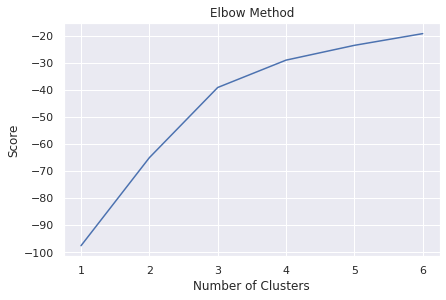

In [ ]:
number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running


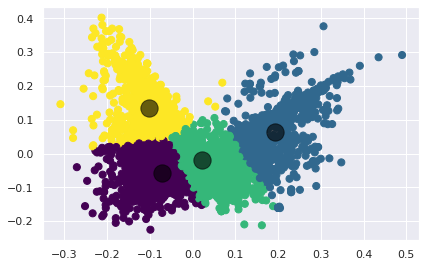

In [ ]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
test_e = Kmeans(4, 1, 600)
fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6)

In [ ]:
from sklearn.cluster import KMeans
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=4, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 15)

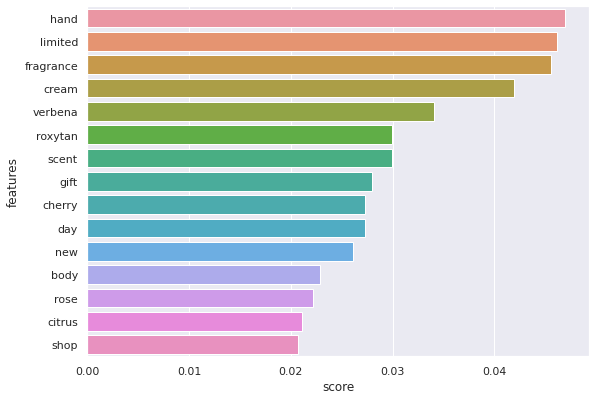

In [ ]:
# Cluster 0
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])

**Cluster 0: Creator** -- Innovation and Imagination, see things people don't

The Cluster emphasizes on creation (*new*, *shop*, *limited*, *gift*) and sense innovation (*fragrance*, *scent*, *rose*, *citrus*). 

Finally, the most used word is *hand* and refers to one of the most well-knowwn creation from the Brand.

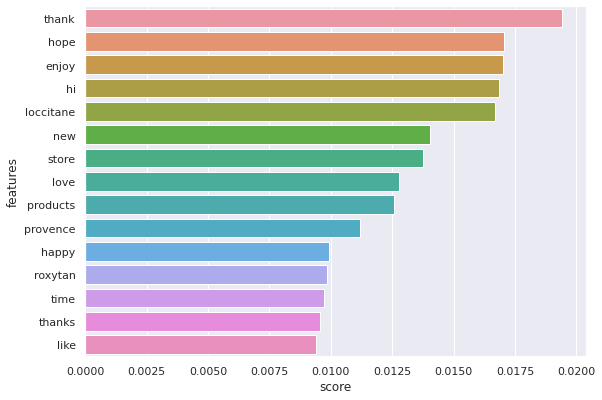

In [ ]:
# Cluster 1
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])

**Cluster 1: Caregiver** -- Desire to give services to others, to help people and spread loving and caring

The Cluster emphasizes on caring (*thank*, *hope*, *enjoy*, *love*, *happy*, *like*). 

Among the most used words, we can see *loccitane* and *provence* which refer to the essence of the brand.

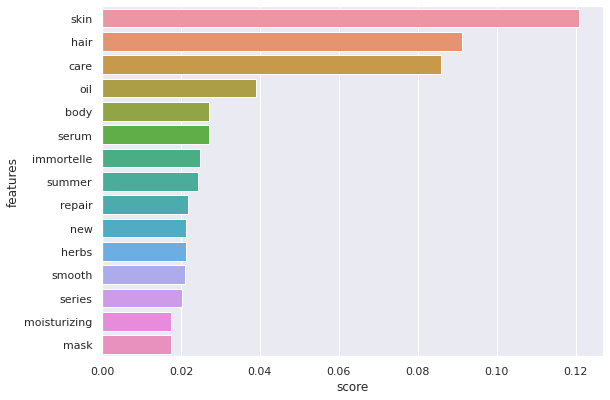

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])

**Cluster 2: Magician** -- Mysteriously powerful, not really understood but seen at a high level

The Cluster emphasizes on the products' features (*repair*, *smooth*, *moisturizing*, *serum*, *herbs*, *oil*). 

These descriptions place the products at a high level with a misterious power on the human body (*skin*, *hair*, *body*)

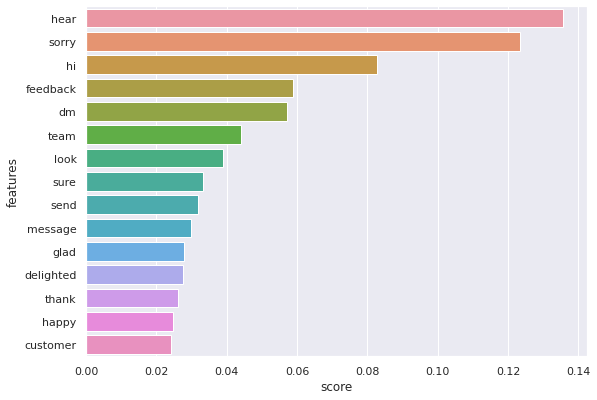

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[3][:15])

**Cluster 3: Innocent** -- Sensible and responsible, with a desire for safety, love and nature 

The Cluster emphasizes one the brands' sensibility for its community (*hi*, *sorry*, *feedback*, *team*, *message*, *sure*, *customers*).

We can also see the presence of various words related to gratitude (*glad*, *delighted*, *thank*, *happy*)

In [ ]:
# add clustering labels
dftweets.insert(0, 'Cluster Labels', kmeans.labels_)

In [ ]:
dftweets['Cluster Labels'].replace({0:'Creator',1:'Caregiver',2:'Magician',3:'Innocent'}, inplace=True)

In [ ]:
# Define Dataset
df_scatter= dftweets[['brand','id','created_at','polarity','compound','likes','nb_words','text_len','Cluster Labels']]
df_scatter['time'] = df_scatter['created_at'].dt.strftime('%Y-%m')

# Set y axis range
ymin, ymax = 0, 350

# Create Scatter plot
fig = px.scatter(df_scatter, x="created_at", y="text_len", color=df_scatter["Cluster Labels"].astype(str), 
                 color_discrete_sequence=[px.colors.qualitative.Safe[0],
                                          px.colors.qualitative.Safe[1],
                                          px.colors.qualitative.Safe[2],
                                          px.colors.qualitative.Safe[3]],
                 title="Twitter Likes through Narrative Arcs")

# Set Plot properties
fig.update_traces(line=dict(dash="scatter", width=1), selector=dict(type="scatter", mode="lines"))
fig.update_yaxes(range=[ymin, ymax],showline=True,linecolor="black",gridcolor="#eee")
fig.update_xaxes(showline=True,linecolor="black")
fig.update_layout(plot_bgcolor='rgb(255,255,255)',title_x=0.5)

# Display Scatter Plot
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



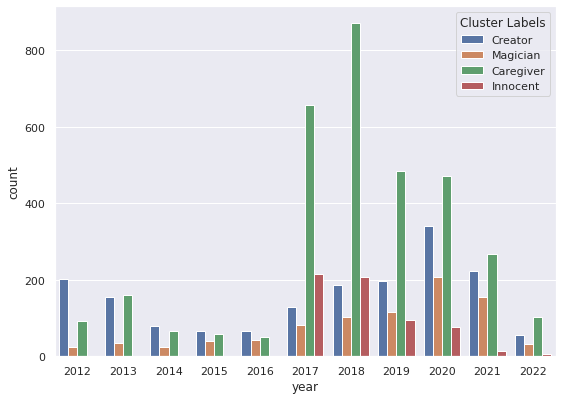

In [ ]:
# Define Dataset
df_count= dftweets[['brand','created_at','text','compound','likes','Cluster Labels']]
df_count['year'] = df_count['created_at'].dt.strftime('%Y')
df_count = df_count.sort_values(by='year')

# Plot Figure
plt.figure(figsize=(8,6))
sns.countplot(x=df_count['year'], hue=df_count['Cluster Labels'], data=df_count,orient = 'v')

In [ ]:
# Define Dataset
df_countuk = dftweets[['brand','created_at','text','compound','likes','Cluster Labels']][dftweets['brand']=='UK']
df_countuk['year'] = df_countuk['created_at'].dt.strftime('%Y')
df_countuk = df_countuk.sort_values(by='year')
df_countuk = df_countuk[['year','Cluster Labels','likes']].groupby(['year','Cluster Labels']).agg('count')
df_countuk = df_countuk.rename(columns = {'likes':'count'})
df_countuk = df_countuk.reset_index()
df_countuk['share'] = df_countuk['count'] / df_countuk.groupby(['year'])['count'].transform('sum')
df_countuk.head()

,year,Cluster Labels,count,share
0,2017,Caregiver,623,0.653725
1,2017,Creator,63,0.066107
2,2017,Innocent,216,0.226653
3,2017,Magician,51,0.053515
4,2018,Caregiver,738,0.690365


In [ ]:
# Define Dataset
df_countuk = dftweets[['brand','created_at','text','compound','likes','Cluster Labels']][dftweets['brand']=='UK']
df_countuk['year'] = df_countuk['created_at'].dt.strftime('%Y')
df_countuk = df_countuk.sort_values(by='year')
df_countuk = df_countuk[['year','Cluster Labels','likes']].groupby(['year','Cluster Labels']).agg('count')
df_countuk = df_countuk.rename(columns = {'likes':'count'})
df_countuk = df_countuk.reset_index()
df_countuk['share'] = df_countuk['count'] / df_countuk.groupby(['year'])['count'].transform('sum')

# Create Bar plot
fig = go.Figure()
col = 0
for t in df_countuk['Cluster Labels'].unique():
    df_c = df_countuk[df_countuk['Cluster Labels']==t]
    fig.add_trace(go.Bar(x=df_c["year"], y=df_c["share"], name=t, base=df_c["Cluster Labels"],
                         marker_color=px.colors.qualitative.Pastel[col]))
    col = col + 1

# Set Bar chart properties 
layout = go.Layout(
    title="Archetypes proportion by year - L'Occitane UK",
    title_x=0.5,
    plot_bgcolor="#FFF",  # Sets background color to white
    xaxis=dict(
        title="Time",
        linecolor="#BCCCDC",  # Sets color of X-axis line
        showgrid=False  # Removes X-axis grid lines
    ),
    yaxis=dict(
        title="Occurence",  
        linecolor="#BCCCDC",  # Sets color of Y-axis line
        showgrid=True,  # Removes Y-axis grid lines    
        gridcolor="#eee"
))
fig.update_layout(layout)

# Display the Bar plot
fig.show()

In [ ]:
# Define Dataset
df_countjp = dftweets[['brand','created_at','text','compound','likes','Cluster Labels']][dftweets['brand']=='JP']
df_countjp['year'] = df_countjp['created_at'].dt.strftime('%Y')
df_countjp = df_countjp.sort_values(by='year')
df_countjp = df_countjp[['year','Cluster Labels','likes']].groupby(['year','Cluster Labels']).agg('count')
df_countjp = df_countjp.rename(columns = {'likes':'count'})
df_countjp = df_countjp.reset_index()
df_countjp['share'] = df_countjp['count'] / df_countjp.groupby(['year'])['count'].transform('sum')

# Create Bar plot
fig = go.Figure()
col = [px.colors.qualitative.Pastel[0],px.colors.qualitative.Pastel[1],px.colors.qualitative.Pastel[3]]
for i in range(0,3):
    df_c = df_countjp[df_countjp['Cluster Labels']==df_countjp['Cluster Labels'][i]]
    fig.add_trace(go.Bar(x=df_c["year"], y=df_c["share"], name=df_countjp['Cluster Labels'][i], base=df_c["Cluster Labels"],
                         marker_color=col[i]))

# Set Bar chart properties 
layout = go.Layout(
    title="Archetypes proportion by year - L'Occitane JP",
    title_x=0.5,
    plot_bgcolor="#FFF",  # Sets background color to white
    xaxis=dict(
        title="Time",
        linecolor="#BCCCDC",  # Sets color of X-axis line
        showgrid=False  # Removes X-axis grid lines
    ),
    yaxis=dict(
        title="Occurence",  
        linecolor="#BCCCDC",  # Sets color of Y-axis line
        showgrid=True,  # Removes Y-axis grid lines    
        gridcolor="#eee"
))
fig.update_layout(layout)

# Display the Bar plot
fig.show()